# Generation Using Idyoms

In [1]:
using DataFrames, Plots, Random
using Chakra
include("src/Idyoms.jl")
using Main.Idyoms

## Load Melch

In [2]:
using Melch
Melch.__INIT__("/Users/nick/Dropbox/MelchData")

## Select Nova Dataset

In [3]:
nova = fnd(Melch.id(0),Melch)
nova.description

"Songs and ballads from Nova Scotia, Canada."

## Generate Sequences

In [4]:
melodies = pts(nova)
sequences = [sequence(pts(mel,Melch),Melch) for mel in melodies];

In [5]:
dump(sequences[1][1])

Melch.Event
  id: Melch.EventId
    dataset: Int64 0
    melody: Int64 1
    event: Int64 1
  ONSET: Int64 0
  DELTAST: Int64 0
  BIOI: Int64 1
  DUR: Int64 24
  CPITCH: Int64 65
  MPITCH: Int64 38
  ACCIDENTAL: Int64 0
  KEYSIG: Int64 -1
  MODE: Int64 0
  BARLENGTH: Int64 48
  PULSES: Int64 2
  PHRASE: Int64 1
  VOICE: Int64 1
  ORNAMENT: Int64 0
  COMMA: Int64 0
  VERTINT12: Chakra.None Chakra.None()
  ARTICULATION: Int64 0
  DYN: Chakra.None Chakra.None()


## Define Viewpoints

In [6]:
CPITCH = vp(Melch.CPITCH)
DUR = vp(Melch.DUR)
CPITCH_X_DUR = link(CPITCH,DUR)

Chakra.LinkedViewpoint{Tuple{Int64, Int64}}(Viewpoint[Chakra.AtomicViewpoint{Int64}(Melch.Attribute{:CPITCH, Int64}(), Type[Int64]), Chakra.AtomicViewpoint{Int64}(Melch.Attribute{:DUR, Int64}(), Type[Int64])], DataType[Int64, Int64])

## Generate Views

In [7]:
p_p = [View(seq,CPITCH,CPITCH) for seq in sequences];
d_d = [View(seq,DUR,DUR) for seq in sequences];
p_d = [View(seq,CPITCH,DUR) for seq in sequences];
d_p = [View(seq,DUR,CPITCH) for seq in sequences];
pxd_pxd = [View(seq,CPITCH_X_DUR,CPITCH_X_DUR) for seq in sequences];

## Set Parameters

In [24]:
o = Bounded(5) # order bound
b = Interpolated() # smoothing technique
e = A() # escape method
u = true # update exclusion

true

## Generate Models

In [25]:
p_p_tally, p_seen = Idyoms.train(p_p,o);
d_d_tally, d_seen = Idyoms.train(d_d,o);
p_d_tally, d_seen = Idyoms.train(p_d,o);
d_p_tally, p_seen = Idyoms.train(d_p,o);
pxd_pxd_tally, pxd_seen = Idyoms.train(pxd_pxd,o);

## Use models to generate new sequences

In [26]:
preds, seq = Idyoms.generate_sequence(100,pxd_pxd_tally,pxd_seen,pxd_seen,b,e,u,o) 

LoadError: ArgumentError: invalid index: nothing of type Nothing

## Display Sequence

In [27]:
Idyoms.mean_infcontent(preds)

2.7386591110275735

In [28]:
df = Idyoms.todataframe(1,preds)

Row,SeqID,EventID,Symbol,Order,Prob,IC,H
,Int64,Int64,Tuple…,Int64,Float64,Float64,Float64
1,1,1,"(62, 24)",0,0.0344949,4.85747,5.69385
2,1,2,"(62, 48)",1,0.0170649,5.87283,4.50203
3,1,3,"(64, 12)",1,0.0333335,4.90688,2.86766
4,1,4,"(67, 24)",1,0.012766,6.29155,3.24347
5,1,5,"(67, 12)",2,0.285714,1.80735,3.15886
6,1,6,"(64, 12)",3,0.333333,1.58496,2.81316
7,1,7,"(62, 12)",2,0.0367647,4.76553,2.3548
8,1,8,"(62, 12)",3,0.166667,2.58496,2.74576
9,1,9,"(62, 48)",4,0.5,1.0,2.37011


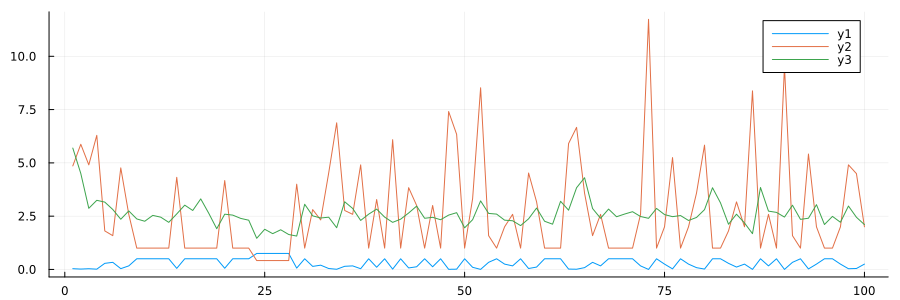

In [29]:
plot(df.Prob)
plot!(df.IC)
plot!(df.H)
plot!(size=(900,300))

In [30]:
using MIDI, Dates
function generatemidifile(xs::Vector{Tuple{Int,Int}},name::String)
    tpq = 960
    notes = Note[]
    pos = 0
    for pair in xs
        pitch = pair[1]
        velocity = 100
        dur = Int(tpq*pair[2]/24)
        
        note = Note(pitch,100,pos,dur)
        
        push!(notes,note)
        pos+=dur
    end
    track = MIDITrack()
    addnotes!(track, notes)
    
    midi = MIDIFile(0, tpq, [track])
    cd(@__DIR__)
    save(name, midi)
end

generatemidifile (generic function with 1 method)

In [23]:
generatemidifile(seq,"example.mid")

MIDIFile (format=0, tpq=960) with 1 tracks